In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [28]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as wrmhole
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl

In [3]:
path = os.getcwd()

In [4]:
Par = [0.8/1.42953, 8.6*2/3, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [5]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = wrmhole.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[12.          3.14159265  1.57079633]
176.6373109817505


In [6]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [7]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [8]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

In [29]:
Motion2 = wrmhole.simulate_raytracer_fullpath(100, Par, initial_q, 2000, 20**2, 20**2, 'RK45')

TypeError: simulate_raytracer_fullpath() takes from 3 to 6 positional arguments but 7 were given

In [10]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

<IPython.core.display.Javascript object>


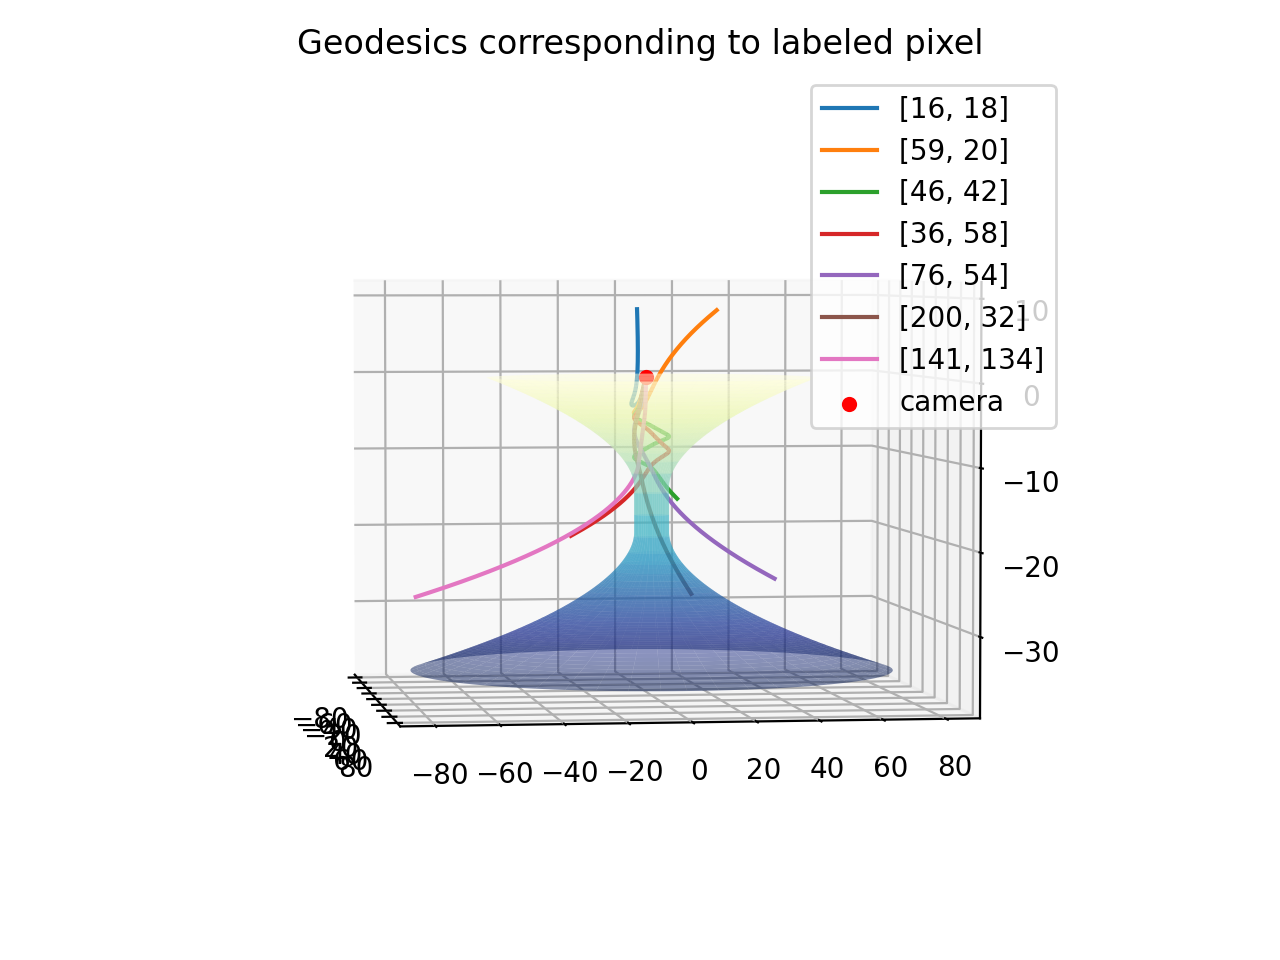

In [12]:
Geo_label = None #list of strings for labeling geodesics, turn Geo_sel to None
#Geo_Sel = None
Geo_Sel = [[16,18],[59,20],[46,42],[36,58],[76,54],[200,32],[141,134]]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [13]:
CM2 = np.array([wrmhole.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


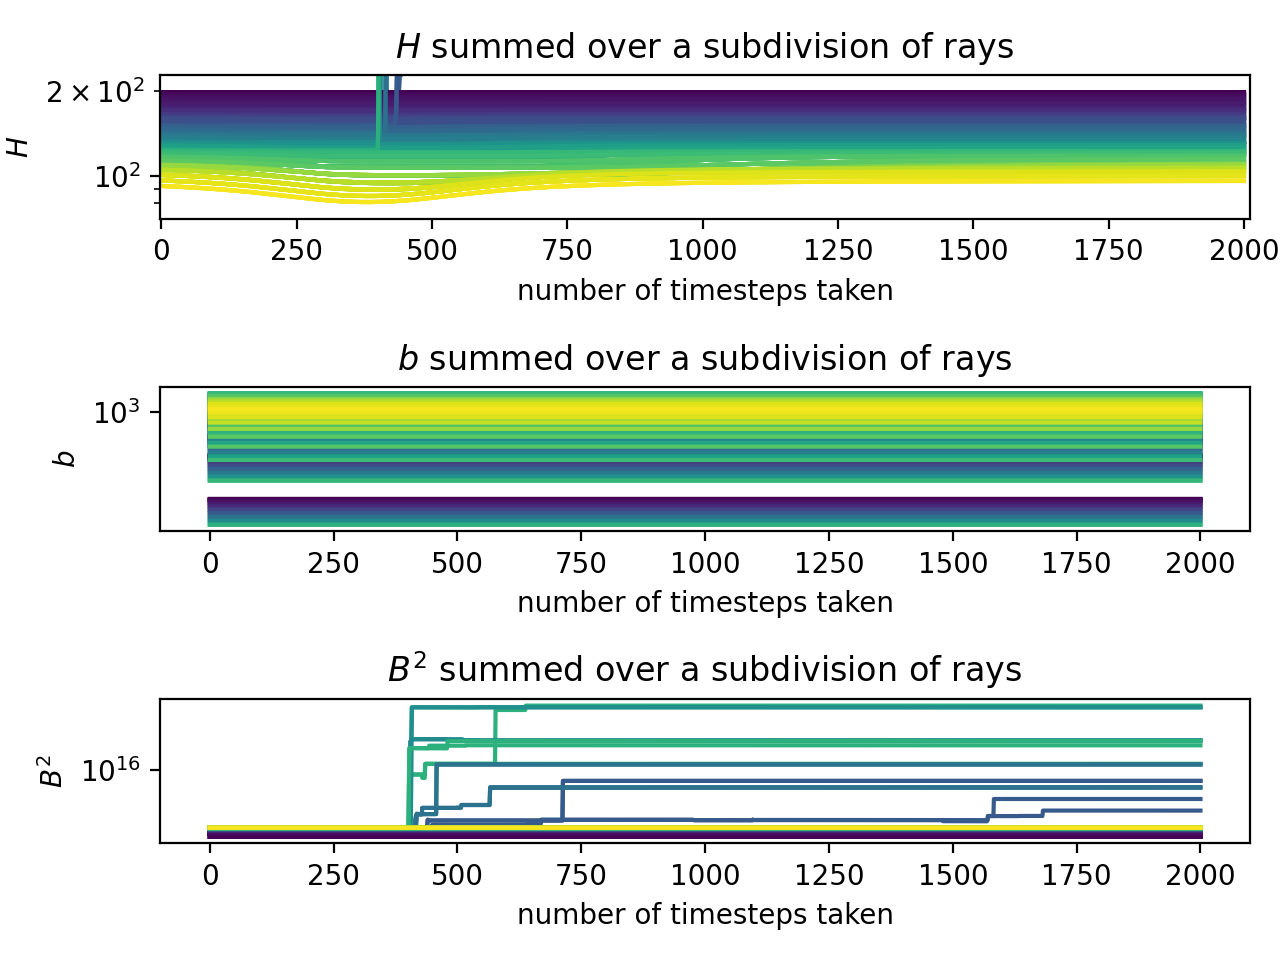

In [14]:
wg.plot_CM(CM1, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


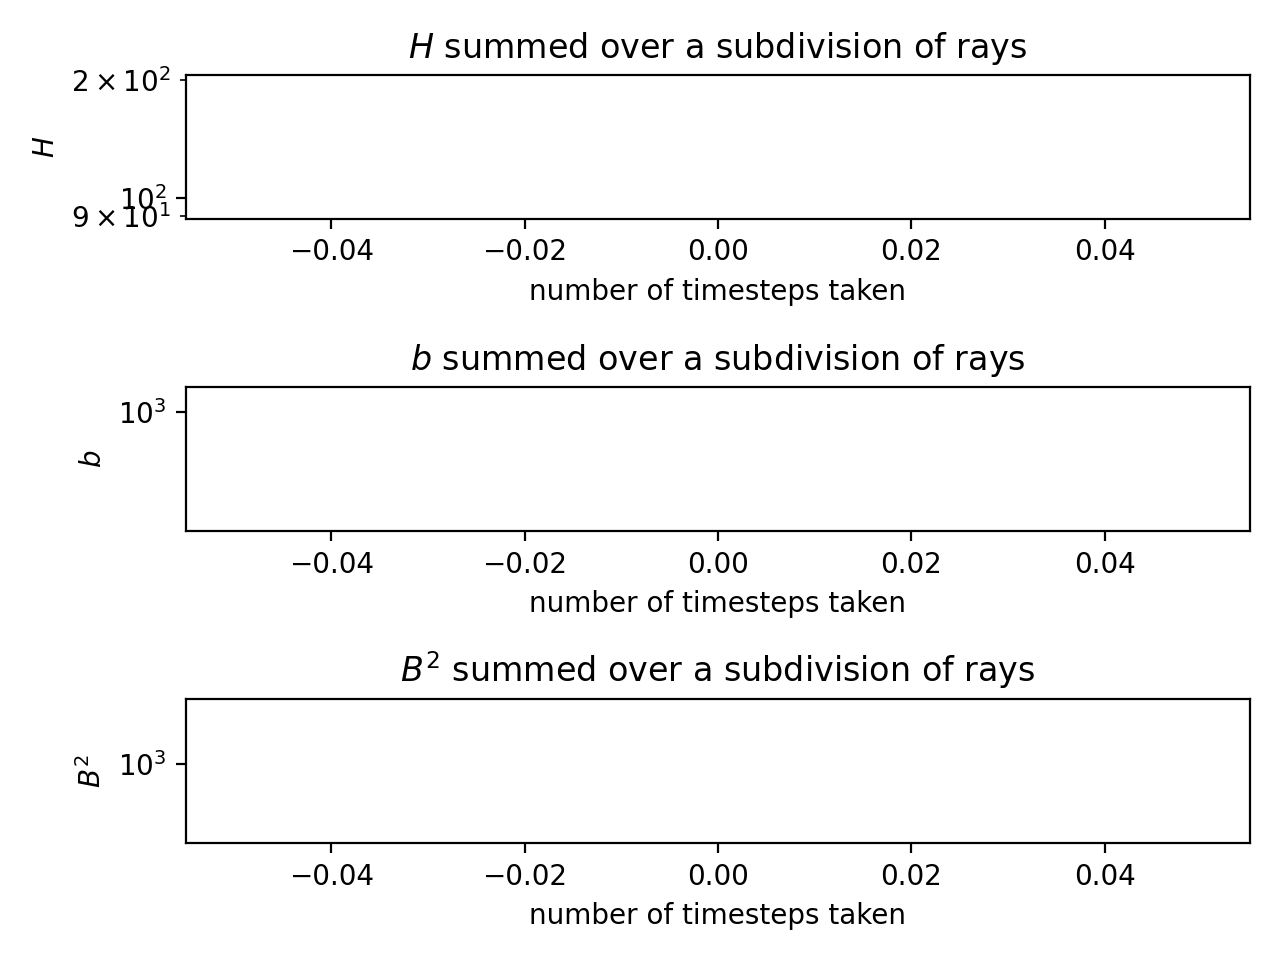

In [15]:
wg.plot_CM(CM2, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg scipy intgr."+str(Par)+" "+str(initial_q)+".png", path)

In [19]:
Motion2.shape

(1, 2, 3, 400, 400)